# Navier Stokes in a pipe flow (stationary 2D) with hard constraints + Estimation of a path of solution

We solve the stationary Navier Stokes PDE:

$$
\begin{cases}
\nabla\cdot\mathbf{u}=0,\\
(\mathbf{u}\cdot\nabla)\mathbf{u} + \frac{1}{\rho}\nabla p - \nu \nabla^2\mathbf{u}=0.
\end{cases}
$$

This becomes in 2D, with $\mathbf{u}=\begin{pmatrix}u_x \\ u_y\end{pmatrix}$


$$
\begin{cases}
\frac{\partial}{\partial x} u_x + \frac{\partial}{\partial y} u_y = 0 \\
\begin{pmatrix}u_x\frac{\partial}{\partial x} u_x + u_y\frac{\partial}{\partial y} u_x \\
u_x\frac{\partial}{\partial x} u_y + u_y\frac{\partial}{\partial y} u_y  \end{pmatrix} +
\frac{1}{\rho} \begin{pmatrix} \frac{\partial}{\partial x} p \\ \frac{\partial}{\partial y} p \end{pmatrix}
- \nu
\begin{pmatrix}
\frac{\partial^2}{\partial x^2} u_x + \frac{\partial^2}{\partial y^2} u_x \\
\frac{\partial^2}{\partial x^2} u_y + \frac{\partial^2}{\partial y^2} u_y
\end{pmatrix} = 0\\
\end{cases}
$$


With the boundary condition:
$$
\begin{cases}
u(x, \frac{d}{2}) = -u(x, \frac{d}{2})=0, \forall x \text{ (boundary condition) }\\
p(x_{min}, y)=0 \text{ and } p(x_{max}, y)=0.1, \forall y \text{ (boundary condition) }
\end{cases}
$$

The domain is defined with $x\in[0,L]$ and $y\in[-R, R]$. __Note__ that because of the central symmetry with respect to the centerline of the tube, we only consider the $y$ axis which will represent the cross section

This notebook aims at reproducing the exampleof section 3.1 of [*Surrogate modeling for fluid flows based on physics-constrained deep learning without simulation data*, Sun et al. 2020](https://www.sciencedirect.com/science/article/pii/S004578251930622X). 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

Float64 and GPU settings

In [2]:
#import os; os.environ["JAX_ENABLE_X64"] = "TRUE" # comment/uncomment to  disable/enable float64 for JAX
#import os; os.environ["CUDA_VISIBLE_DEVICES"]="" # If uncommented then GPU is disable

Import our package

In [3]:
import jinns

/home/hugo/anaconda3/envs/pinn2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Import other dependencies

In [4]:
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial
import matplotlib.pyplot as plt

key = random.PRNGKey(2)

Create the neural network architecture for the PINN with `equinox`. We have two Pinns for the velocity field `u` and for the pressure field `p`. The first one is vectorial (2D) the second one is scalar.

In [5]:
eqx_list = [
    [eqx.nn.Linear, 3, 50],
    [jax.nn.swish],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.swish],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.swish],
    [eqx.nn.Linear, 50, 50],
    [jax.nn.swish],
    [eqx.nn.Linear, 50, 3],
]
key, subkey = random.split(key)
u_init_param_fn, u_raw = jinns.utils.create_PINN(subkey, eqx_list, "statio_PDE", 2, with_eq_params=['nu'])

# eqx_list = [
#     [eqx.nn.Linear, 3, 50],
#     [jax.nn.tanh],
#     [eqx.nn.Linear, 50, 50],
#     [jax.nn.tanh],
#     [eqx.nn.Linear, 50, 50],
#     [jax.nn.tanh],
# #     [eqx.nn.Linear, 50, 50],
# #     [jax.nn.tanh],
# #     [eqx.nn.Linear, 50, 50],
# #     [jax.nn.tanh],
#     [eqx.nn.Linear, 50, 1],
# ]
# key, subkey = random.split(key)
# p_init_param_fn, p_raw = jinns.utils.create_PINN(subkey, eqx_list, "statio_PDE", 2, with_eq_params=['nu'])

In [6]:
u_init_nn_params = u_init_param_fn()
p_init_nn_params = u_init_nn_params

Create a DataGenerator object and set up some geometry. Following the [authors' implementation](https://github.com/Jianxun-Wang/LabelFree-DNN-Surrogate/blob/master/Tutorial/PipeFlow.ipynb), we set a pipe length $L=1$ and a pipe radius$R=0.05$. Following the authors, we also simplify the problem because of its geometry: the solution is symmetric with respect to the center of the pipe, at a given point $x\in[0, L]$. Therefore we only need one axis representing a pipe cross section and one axis representing the pipe length.

In [7]:
L = 1
R = 0.05

p_out = 0
p_in = 0.1

In [8]:
n = 1000
nb = None
omega_batch_size = 32
omega_border_batch_size = None
dim = 2
xmin = 0
xmax = xmin + L
ymin = -R
ymax = ymin + 2 * R
# zmin = -R
# zmax = zmin + 2 * R

method = "uniform"
key, subkey = random.split(key)
train_data = jinns.data.CubicMeshPDEStatio(
    subkey,
    n,
    nb,
    omega_batch_size,
    omega_border_batch_size,
    dim,
    (xmin, ymin),
    (xmax, ymax),
    method,
    False
)

__Note:__ that we choose a very simple data generator and no boundary condition despite the pipe-like geometry. Indeed, we choose to follow the author's hard coded boundary constraints. The neural network outputs are then multiplied with a factor which enforces the constraints. We impose the so-called _slip-condition_ on the borders, ie, the fluid has a null speed on the borders.

In [9]:
u = lambda x, nn_params, eq_params: u_raw(x, nn_params, eq_params)[:2] * (R ** 2 - x[1] ** 2) # multiplies the 2 componentse

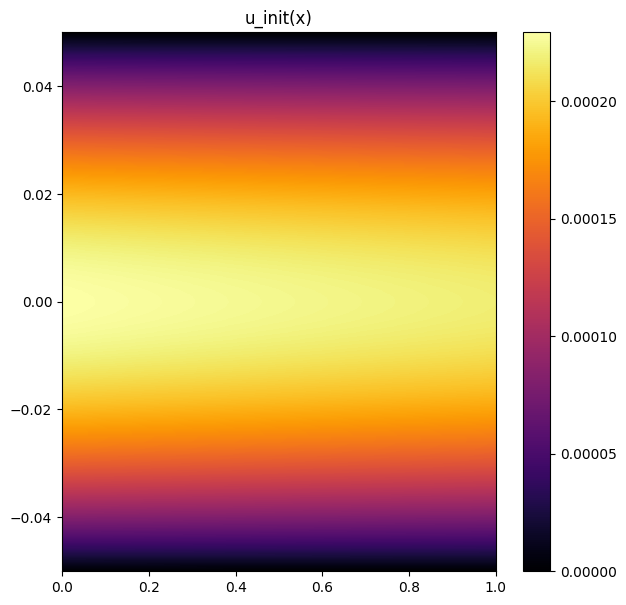

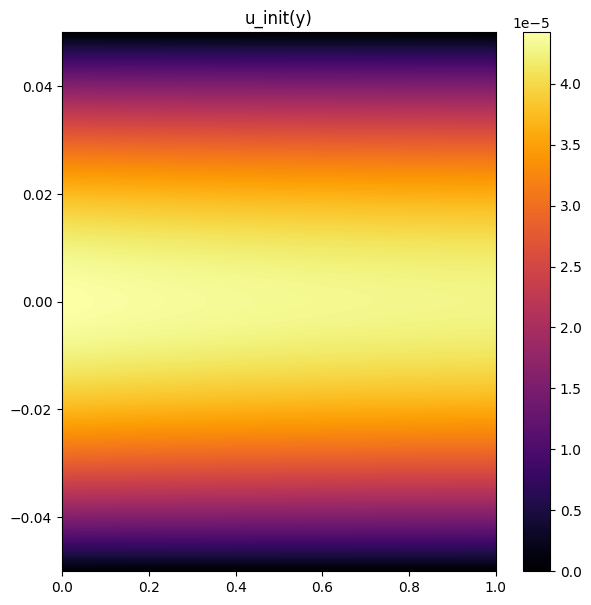

In [10]:
nx, ny = 1000, 1000
val_xy_data = [jnp.linspace(xmin, xmax, nx),
               jnp.linspace(ymin, ymax, ny)
              ]

u_xinit = lambda x: u(x, u_init_nn_params, {"rho":1., "nu":jnp.array(0.0004)})[0]
jinns.data.plot2d(
    fun=u_xinit,
    xy_data=val_xy_data,
    title="u_init(x)"
)

u_yinit = lambda x: u(x, u_init_nn_params, {"rho":1., "nu":jnp.array(0.0004)})[1]
jinns.data.plot2d(
    fun=u_yinit,
    xy_data=val_xy_data,
    title="u_init(y)"
)

We also impose the pressure inlet and outlet condition

In [11]:
p = lambda x, nn_params, eq_params: (x[0] - xmin) / (xmax - xmin) * p_out + (xmax - x[0]) / (xmax - xmin) * p_in + (xmin-x[0]) * (xmax - x[0]) * u_raw(x, nn_params, eq_params)[2]

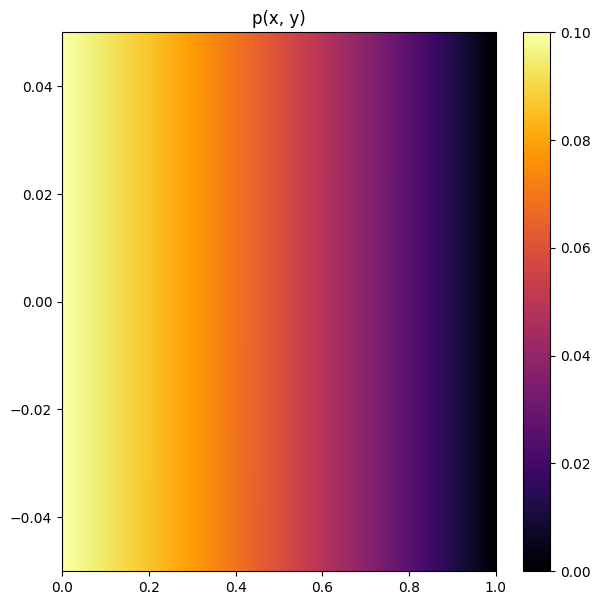

In [12]:
jinns.data.plot2d(
    fun = lambda x: p(x, p_init_nn_params, {"rho":1., "nu":jnp.array(0.0004)}),
    xy_data=val_xy_data,
    title = "p(x, y)"
)

In [13]:
method = "grid"
key, subkey = random.split(key)
np = 1000
param_batch_size = 32
param_train_data = jinns.data.DataGeneratorParameter(
    subkey,
    np,
    param_batch_size,
    {'nu':(2e-4, 1.9e-3)},
    method,
)

## Model parameters

Here we set the density $\rho=1$ and we simplify the problem with respect to the article: $\nu$ is the viscosity parameter which we fix and feed as input to the PINN as done in the article; $\nu=0.00061$

In [14]:
rho = 1.
nu = 0.00061

Delta_p = 0.1
d = 2 * R

A set of parameters as required by the losses' `evaluate`. Here we adapt to the particular dynamic loss which requires the keys `u` and `p`.

In [15]:
# initiate parameters dictionary
init_params = {}
init_params['nn_params'] = {
    "u": u_init_nn_params,
    "p": p_init_nn_params
}
init_params["eq_params"] = {"rho":rho, **param_train_data.get_batch()} # NOTE the additional batch is a dict 

## Analytical solution
In this case, the analytical solution is known:
$$
u_a = \frac{\Delta p}{2\nu\rho L}(\frac{d^2}{4} - y^2)
$$

Text(0.5, 1.0, 'True solution along a cross section')

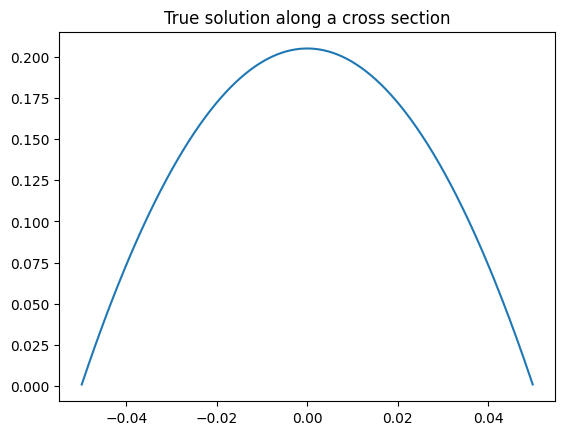

In [16]:
def u_true(y, nu=nu):
    return Delta_p / (2 * nu * rho * L) * ((d / 2) ** 2 - y ** 2)

plt.plot(train_data.omega[:, 1].sort(axis=0), vmap(u_true, (0), 0)(train_data.omega[:, 1].sort(axis=0)))
plt.title(r"True solution along a cross section")

## Loss construction

In [17]:
mc_loss = jinns.loss.MassConservation2DStatio(nn_key='u')
ns_loss = jinns.loss.NavierStokes2DStatio(u_key='u', p_key='p')

In [18]:
loss_weights = {"dyn_loss":1.}
    
loss = jinns.loss.SystemLossPDE(
    u_dict={'u':u, 'p':p},
    loss_weights=loss_weights,
    dynamic_loss_dict={'mass_conservation':mc_loss, 'navier_stokes':ns_loss},
    nn_type_dict={'u':'nn_statio', 'p':'nn_statio'}
)

/home/hugo/Documents/recherche/pinn/gitlab/jinns/loss/_LossPDE.py:284: UserWarning: Missing boundary function or no boundary condition.Boundary function is thus ignored.
  warnings.warn(


In [19]:
# Testing the loss function
losses_and_grad = jax.value_and_grad(loss.evaluate, 0, has_aux=True)
losses, grads = losses_and_grad(
    init_params,
    batch = train_data.get_batch() + (param_train_data.get_batch(),)
)


l_tot, dict_losses = losses
print(f"total loss: {l_tot:.2f}")
print(f"Individual losses: { {key: f'{val:.2f}' for key, val in dict_losses.items()} }")

total loss: 0.01
Individual losses: {'boundary_loss': '0.00', 'dyn_loss': '0.01', 'norm_loss': '0.00', 'observations': '0.00'}


## Learning the neural network parameters
The learning process here consider known equation parameters `eq_params`. We thus only update `nn_params`

In [20]:
params = init_params

In [21]:
# Optimizer
import optax
from jaxopt import OptaxSolver


tx = optax.adam(learning_rate=1e-3)
solver = OptaxSolver(opt=tx, fun=loss,
                     has_aux=True, # because the objective has aux output
                     maxiter=50000)


In [22]:
n_iter = int(150000)
pinn_solver = jinns.solver.PinnSolver(
    optax_solver=solver,
    loss=loss,
    n_iter=n_iter
)

In [23]:
params, total_loss_list, loss_by_term_dict, _, _ = pinn_solver.solve(
    init_params=params,
    data=train_data,
    param_data=param_train_data
)

Running for 150,000 iterations: 100%|██| 150000/150000 [05:57<00:00, 420.11it/s]


## Results

Plot the loss values

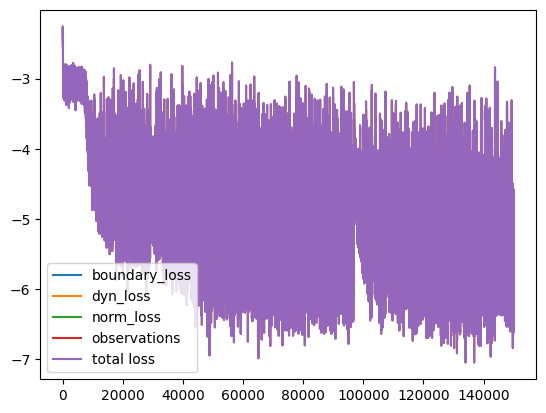

In [24]:
for loss_name, loss_values in loss_by_term_dict.items():
    plt.plot(jnp.log10(loss_weights[loss_name] * loss_values), label=loss_name)
plt.plot(jnp.log10(total_loss_list), label="total loss")
plt.legend()
plt.show();

Plot the ODE solutions learned by the PINN

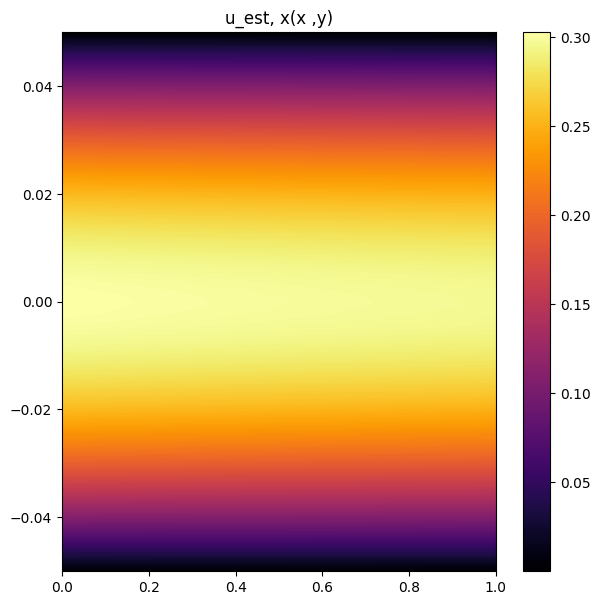

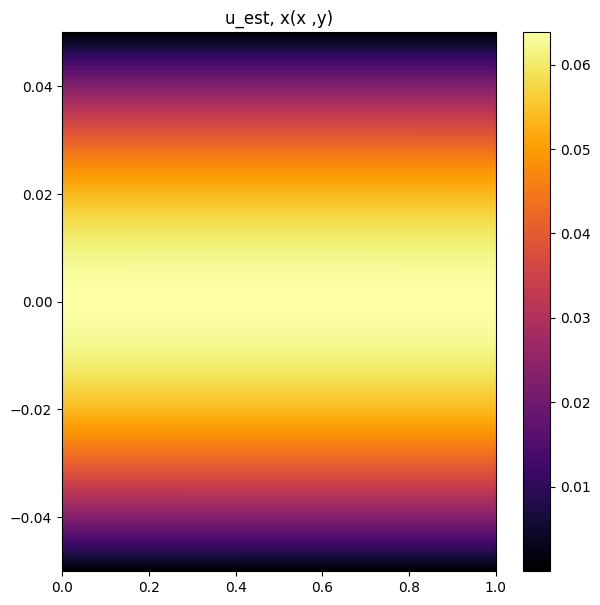

In [25]:
jinns.data.plot2d(
    fun = lambda x: jnp.linalg.norm(u(x, params['nn_params']['u'], {"rho":rho, "nu":jnp.array(0.0004)})),#[0],
    xy_data = val_xy_data,
    title="u_est, x(x ,y)"
)

jinns.data.plot2d(
    fun = lambda x: jnp.linalg.norm(u(x, params['nn_params']['u'], {"rho":rho, "nu":jnp.array(0.0019)})),#[0],
    xy_data = val_xy_data,
    title="u_est, x(x ,y)"
)

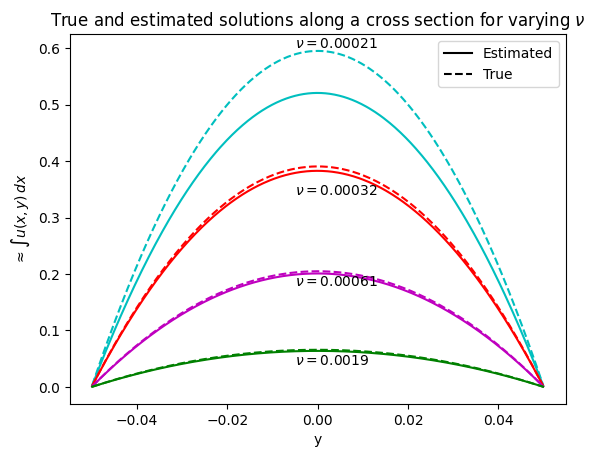

In [27]:
v_u_est_y_nu = lambda x, y_j, nu:vmap(
    # compute average over array x with y_j fixed.
    lambda x, y_j: vmap(lambda z: u(jnp.stack([z, y_j], axis=-1), params["nn_params"]["u"], {"rho":rho, "nu":jnp.array(nu)})[0], 
                        0, 0)(x).mean(), 
    (None, 0), 
    0)(x, y_j)

for nu, c in zip([0.00021, 0.00032, 0.00061, 0.0019], ['c', 'r', 'm', 'g']):
    plt.plot(
        train_data.omega[:, 1].sort(axis=0),
        v_u_est_y_nu(
            train_data.omega[:, 0].sort(axis=0),
            train_data.omega[:, 1].sort(axis=0),
            nu),
        c
    )

    plt.plot(train_data.omega[:, 1].sort(axis=0),
             vmap(lambda x: u_true(x, nu=nu), (0), 0)(train_data.omega[:, 1].sort(axis=0)),
             c + '--'
    )

plt.xlabel("y")
plt.ylabel(r"$\approx \int u(x, y) \, dx$")
line1, = plt.plot([0], "k", label='Estimated')
line2, = plt.plot([0], "k--", label='True')
plt.text(-0.005, 0.6, r"$\nu=0.00021$")
plt.text(-0.005, 0.34, r"$\nu=0.00032$")
plt.text(-0.005, 0.18, r"$\nu=0.00061$")
plt.text(-0.005, 0.04, r"$\nu=0.0019$")
plt.legend(handles=[line1,line2])
plt.title(r"True and estimated solutions along a cross section for varying $\nu$")
plt.show()